In [29]:
import os
import cv2
import copy
import time
import json
import codecs
import base64
import shutil
import numpy as np
from PIL import Image
from ctypes import *
from io import BytesIO
from logzero import setup_logger
from flask import Flask, request, jsonify, make_response

import Config.MainConfig as Config
from util import Face_data_class, Serverce
import License.Source_license as Source_license

Config = Config.Config()

# 首次登陆需要上传user,人脸图片，构造一函数接收参数，返回人脸特征。

## --------- 不需要存储用户人脸特征，直接网络传输-------------

In [30]:
class AIFaceCompare():
    
    def __init__(self,):
        self.logger = setup_logger(name="AIFaceCompare",logfile=Config.Face_Log)
#         self.logger = getlogger.get_logger(Config.Face_Log)
        license, Face_read_so = Source_license.source()
        assert license, "Source License Error!"
        ret, self.Handle = Serverce.Initialize()
        self.logger.info("Initialize Successfully:{}! Handle:{}".format(ret,self.Handle))
        self.Face_read_so = Face_read_so
        self.image_data = None
        self.handle_data = None
        self.width = 0
        self.height = 0
        self.MulFaces = Face_data_class.ASF_MultiFaceInfo() #多人脸特征
        self.DetectedFaces = Face_data_class.ASF_FaceFeature() #人脸特征
        self.SingleFaces = Face_data_class.ASF_SingleFaceInfo() #单人脸特征
        
    def pre_image(self,base64_encode_image_data):
        assert isinstance(base64_encode_image_data,bytes),"Image Data Is Not Bytes!"
        try:
            decode_image = base64.b64decode(base64_encode_image_data)
            image_data = BytesIO(decode_image)
            image_data = Image.open(image_data)
            image_data = np.array(image_data)[...,::-1]
            return image_data
        except:
            self.logger.error("The Image Can not Read！")
            return False
        
    def LoadImg(self,image_data):
        self.image_data = image_data
        sp = image_data.shape
        image = cv2.resize(image_data,(sp[1]//4*4,sp[0]//4*4))
        sp = image.shape
        self.handle_data = image
        self.width = sp[1]
        self.height = sp[0]
        
    def MultiFaceInfo(self,):
        self.image_bytes = bytes(self.handle_data)
        self.image_cast_bytes = cast(self.image_bytes, Serverce.c_ubyte_p)
        Face_result = self.Face_read_so.Discern(
                                                self.Handle,
                                                self.width,
                                                self.height,
                                                0x201,
                                                self.image_cast_bytes,
                                                byref(self.MulFaces))
        return Face_result
    
    def GetSingleFace(self,): 
        self.logger.info("Get Single Face (left,right,top,bottom) Information!")
        ra = self.MulFaces.faceRect[0]
        self.SingleFaces.faceRect.left1 = ra.left1
        self.SingleFaces.faceRect.right1 = ra.right1
        self.SingleFaces.faceRect.top1 = ra.top1
        self.SingleFaces.faceRect.bottom1 = ra.bottom1
        self.SingleFaces.faceOrient = self.MulFaces.faceOrient[0]
    
    def GetFeature(self,):
        result = self.Face_read_so.Feature(
                                            self.Handle,
                                            self.width,
                                            self.height,
                                            0x201,
                                            self.image_cast_bytes,
                                            self.SingleFaces,
                                            byref(self.DetectedFaces))
        if result == 0:
            self.logger.info("Get Feature Successfully!")
            NewDetectedFaces = Face_data_class.ASF_FaceFeature()
            NewDetectedFaces.featureSize = self.DetectedFaces.featureSize
            NewDetectedFaces.feature = self.Face_read_so.malloc(self.DetectedFaces.featureSize)
            self.Face_read_so.memcpy(NewDetectedFaces.feature, self.DetectedFaces.feature, self.DetectedFaces.featureSize)
            return NewDetectedFaces
        else:
            self.logger.error("Get Nothing,Invalid Face Information! ERROR CODE:{0}".format(result))
            return result
        
    def Liveness(self,):
        ret = self.Face_read_so.Process(
                                        self.Handle,
                                        self.width,
                                        self.height,
                                        self.Face_read_so.PAF_RGB24_B8G8R8,
                                        self.image_cast_bytes,
                                        byref(self.MulFaces),
                                        c_int32(self.Face_read_so.ASF_LIVENESS))
        
        LivenessInfo = Face_data_class.ASF_LivenessInfo()
        result = self.Face_read_so.Liveness(self.Handle, LivenessInfo)
        if result != 0:
            self.logger.error("Liveness Is Error, ERROR CODE:{0}".format(result))
            return 0
        elif LivenessInfo.size !=1:
            self.logger.error("Too Many People Were Detected!")
            return 0
        elif LivenessInfo.islive[0] == 1:
            self.logger.info("Detected Successfully! Is Live！")
            return 1
        elif LivenessInfo.islive[0] == 0:
            self.logger.info("Detected Successfully! Is Died!")
            return 0
        else:
            return 0
        
    def SingleFaceCompare(self, feature1, feature2):
        score = c_float()
        result = self.Face_read_so.Compare(self.Handle, feature1, feature2, byref(score))
        return result, score.value
        
    def ExtractFeatureFromMemory(self, base64_encode_image_data):
        assert isinstance(base64_encode_image_data,bytes),"Image Data Is Not Bytes!"
        image_data = self.pre_image(base64_encode_image_data)
        self.LoadImg(image_data)
        self.MultiFaceInfo()
        self.GetSingleFace()
        Feature = self.GetFeature()
        LiveScore = self.Liveness()
        
        try:
            FeatureLocal = BytesIO(string_at(Feature.feature, Feature.featureSize))
            FeatureLocalBytes = FeatureLocal.getvalue()
            self.logger.info("Extract Feature From Memory Successfully！")
            return FeatureLocalBytes, LiveScore
        except:
            self.logger.error("Get Nothing,Invalid Face Information! ERROR CODE:{0}".format(Feature))
            return Feature, LiveScore
        
    def CopyTheFeatureIntoMemory(self,feature):
        try:
            Feature2 = Face_data_class.ASF_FaceFeature()
            Feature2.featureSize = feature.__len__()
            Feature2.feature = self.Face_read_so.malloc(Feature2.featureSize)
            self.Face_read_so.memcpy(Feature2.feature, feature, Feature2.featureSize)
            return Feature2
        except:
            self.logger.error("It Is Not Feature.It Is a Error Number! ERROR CODE:{0}".format(feature))
            return feature
    
    def CompareFaceFeature(self, base64_encode_image_data, feature):
        assert isinstance(feature,bytes),"Feature Is Not Bytes!"
        assert isinstance(base64_encode_image_data,bytes),"Image Data Is Not Bytes!"
        Feature1, LiveScore = self.ExtractFeatureFromMemory(base64_encode_image_data)
        Feature1 = self.CopyTheFeatureIntoMemory(Feature1)
        if isinstance(Feature1, int):
            return 0,0,0
        Feature2 = self.CopyTheFeatureIntoMemory(feature)
        if isinstance(Feature2, int):
            return 0,0,0
        result,comparescore = self.SingleFaceCompare(Feature1, Feature2)
        if result == 0:
            self.logger.info("Face Comparison Successfully!")
            return result, comparescore, LiveScore
        else:
            self.logger.info("Face Comparison Failed！")
            return result, 0, 0

# 测试--->输入一张经过base64编码后的图片，得出人脸特征。

In [31]:
FaceCompare = AIFaceCompare()

[I 201216 00:49:16 <ipython-input-30-53d589a5bf43>:9] Initialize Successfully:0! Handle:c_void_p(93841387215648)


In [32]:
import matplotlib.pyplot as plt

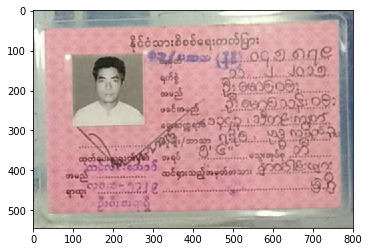

In [33]:
test_image_path = 'images_surui/group1/P0360_001.jpg'
test_image_info = cv2.imread(test_image_path)
plt.imshow(test_image_info[:,:,::-1])
base64_encode_image_data = base64.b64encode(open(test_image_path,'rb').read())

In [34]:
type(base64_encode_image_data)

bytes

In [35]:
feature,Livescore = FaceCompare.ExtractFeatureFromMemory(base64_encode_image_data)

[I 201216 00:49:21 <ipython-input-30-53d589a5bf43>:53] Get Single Face (left,right,top,bottom) Information!
[I 201216 00:49:22 <ipython-input-30-53d589a5bf43>:71] Get Feature Successfully!
[I 201216 00:49:22 <ipython-input-30-53d589a5bf43>:103] Detected Successfully! Is Died!
[I 201216 00:49:22 <ipython-input-30-53d589a5bf43>:125] Extract Feature From Memory Successfully！


In [36]:
type(feature)

bytes

In [14]:
type(Livescore)

int

# 测试--->输入一张经过base64编码后的图片+首次登陆提取出的特征，对比

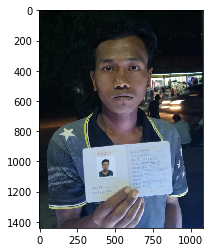

In [50]:
test_image_path = 'images_surui/group/P0035_001.jpg'
test_image_info = cv2.imread(test_image_path)
plt.imshow(test_image_info[:,:,::-1])
base64_encode_image_data = base64.b64encode(open(test_image_path,'rb').read())

In [51]:
result,comparescore,livescore = FaceCompare.CompareFaceFeature(base64_encode_image_data, feature)

[I 201210 17:44:09 <ipython-input-2-53d589a5bf43>:53] Get Single Face (left,right,top,bottom) Information!
[I 201210 17:44:09 <ipython-input-2-53d589a5bf43>:71] Get Feature Successfully!
[I 201210 17:44:09 <ipython-input-2-53d589a5bf43>:100] Detected Successfully! Is Live！
[I 201210 17:44:09 <ipython-input-2-53d589a5bf43>:125] Extract Feature From Memory Successfully！
[I 201210 17:44:09 <ipython-input-2-53d589a5bf43>:154] Face Comparison Successfully!


In [52]:
comparescore

0.0911250039935112

In [25]:
livescore

1

In [41]:
app = Flask(__name__)

In [42]:
@app.route('/face_recognition/face_feature_extraction', methods=['POST'])
def face_feature_extraction():
    data = json.loads(request.get_data(as_text=True))
    if not data:
        results = {"msg": "未得到数据", "rspCode": "2998"}
        response = make_response(jsonify(results))
        response.headers['Content-Type'] = 'application/json;charset=UTF-8'
        return response
    try:
        username = data["username"]
        fileName = data["fileName"]
        face_image = data["imageData"]
        assert fileName
        assert username
        assert face_image
    except Exception as e:
        results = {"msg": "请求参数错误", "rspCode": "2998"}
        response = make_response(jsonify(results))
        response.headers['Content-Type'] = 'application/json;charset=UTF-8'
        return response
    try:
        if isinstance(face_image,str):
            base64_encode_image_data = bytes(face_image,encoding="utf8")
        feature,Livescore = FaceCompare.ExtractFeatureFromMemory(base64_encode_image_data)
        if isinstance(feature, int):
            results ={
                "msg": "照片不可用！",
                "fileName":fileName,
                "rspCode": "2998",
                "username": username, 
                "liveness": Livescore,
                "feature": "",
            }
            response = make_response(jsonify(results))
            response.headers['Content-Type'] = 'application/json;charset=UTF-8'
            return response
        else:
            feature = str(feature)[2:-1]
            if Livescore == 0:
                results ={
                    "msg": "非活体", 
                    "rspCode": "2998",
                    "fileName":fileName,
                    "username": username, 
                    "liveness": Livescore,
                    "feature": feature,
            }
                response = make_response(jsonify(results))
                response.headers['Content-Type'] = 'application/json;charset=UTF-8'
                return response
            else:
                results ={
                    "msg": "请求成功", 
                    "rspCode": "0000",
                    "fileName":fileName,
                    "username": username, 
                    "liveness": Livescore,
                    "feature": feature,
                }
                response = make_response(jsonify(results))
                response.headers['Content-Type'] = 'application/json;charset=UTF-8'
                return response
    except Exception as e:
        results = {"msg": "内部错误", "rspCode": "2998"}
        response = make_response(jsonify(results))
        response.headers['Content-Type'] = 'application/json;charset=UTF-8'
        return response

@app.route('/face_recognition/face_feature_compare', methods=['POST'])
def face_feature_compare():
    data = json.loads(request.get_data(as_text=True))
    if not data:
        results = {"msg": "未得到数据", "rspCode": "2998"}
        response = make_response(jsonify(results))
        response.headers['Content-Type'] = 'application/json;charset=UTF-8'
        return response
    try:
        username = data["username"]
        fileName = data["fileName"]
        face_image = data["imageData"]
        feature = data["feature"]
        assert fileName
        assert username
        assert face_image
        assert feature
    except Exception as e:
        results = {"msg": "请求参数错误", "rspCode": "2998"}
        response = make_response(jsonify(results))
        response.headers['Content-Type'] = 'application/json;charset=UTF-8'
        return response
    try:
        if isinstance(face_image,str):
            base64_encode_image_data = bytes(face_image,encoding="utf8")
        if isinstance(feature, str):
            feature = codecs.escape_decode(feature,'hex-escape')[0]
        start_time = time.time()
        result,comparescore,Livescore = FaceCompare.CompareFaceFeature(base64_encode_image_data, feature)
        identical = 1 if comparescore >= 0.78 else 0
        # identical = comparescore
        if identical == Livescore == 1:
            results ={
                "msg": "请求成功", 
                "rspCode": "0000",
                "username": username, 
                "liveness": Livescore,
                "identical": identical,
                "fileName":fileName
            }
            response = make_response(jsonify(results))
            response.headers['Content-Type'] = 'application/json;charset=UTF-8'
            return response
        elif Livescore == 0:
            results ={
                "msg": "非活体", 
                "rspCode": "2998",
                "username": username, 
                "liveness": Livescore,
                "identical": identical,
                "fileName":fileName
            }
            response = make_response(jsonify(results))
            response.headers['Content-Type'] = 'application/json;charset=UTF-8'
            return response
        elif identical == 0:
            results ={
                "msg": "非同一个人", 
                "rspCode": "2998",
                "username": username, 
                "liveness": Livescore,
                "identical": identical,
                "fileName":fileName
            }
            response = make_response(jsonify(results))
            response.headers['Content-Type'] = 'application/json;charset=UTF-8'
            return response
    except Exception as e:
        results = {"msg": "内部错误", "rspCode": "2998"}
        response = make_response(jsonify(results))
        response.headers['Content-Type'] = 'application/json;charset=UTF-8'
        return response

In [ ]:
if __name__ == "__main__":
    app.config['JSON_AS_ASCII'] = False
    app.config['JSON_SORT_KEYS'] = False
    app.run(host='0.0.0.0', port=5015, debug=False, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5015/ (Press CTRL+C to quit)
[I 201216 03:45:43 <ipython-input-30-53d589a5bf43>:53] Get Single Face (left,right,top,bottom) Information!
[E 201216 03:45:43 <ipython-input-30-53d589a5bf43>:78] Get Nothing,Invalid Face Information! ERROR CODE:86022
[E 201216 03:45:43 <ipython-input-30-53d589a5bf43>:97] Too Many People Were Detected!
[E 201216 03:45:43 <ipython-input-30-53d589a5bf43>:128] Get Nothing,Invalid Face Information! ERROR CODE:86022
127.0.0.1 - - [16/Dec/2020 03:45:43] "POST /face_recognition/face_feature_extraction HTTP/1.1" 200 -
